/GPUFS/sysu_lhong_1/.conda/envs/pytorchgpu/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(20, 2)
epoch 0, gradient: 4.92947e+02, loss: 3.46888e+02, loss_u: 1.37205e+02, loss_f: 1.93755e-01, loss_0: 2.09490e+02, loss_c: 1.42245e-03, loss_c0: 2.02660e+00, mse: 1.03923e+02
epoch 100, gradient: 5.29323e+00, loss: 4.87784e+01, loss_u: 3.64843e+01, loss_f: 1.46046e+00, loss_0: 1.08337e+01, loss_c: 1.96417e-01, loss_c0: 1.54195e+00, mse: 1.01674e+01
epoch 200, gradient: 4.69349e+01, loss: 3.45001e+01, loss_u: 2.97236e+01, loss_f: 1.60099e+00, loss_0: 3.17554e+00, loss_c: 2.14002e-01, loss_c0: 6.32926e-01, mse: 9.02145e+00
epoch 300, gradient: 4.66819e+01, loss: 8.95545e+00, loss_u: 7.26967e+00, loss_f: 1.38121e+00, loss_0: 3.04574e-01, loss_c: 1.21872e+00, loss_c0: 1.65202e-01, mse: 9.41696e+00
epoch 400, gradient: 4.17301e+01, loss: 2.10816e+00, loss_u: 1.29730e+00, loss_f: 7.45153e-01, loss_0: 6.57084e-02, loss_c: 1.02850e+00, loss_c0: 5.30354e-02, mse: 8.60752e+00
The training process using adam is finished!
epoch 500, gradient: 3.76133e+00, loss: 9.36639e-01, loss_u: 4.11734e

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


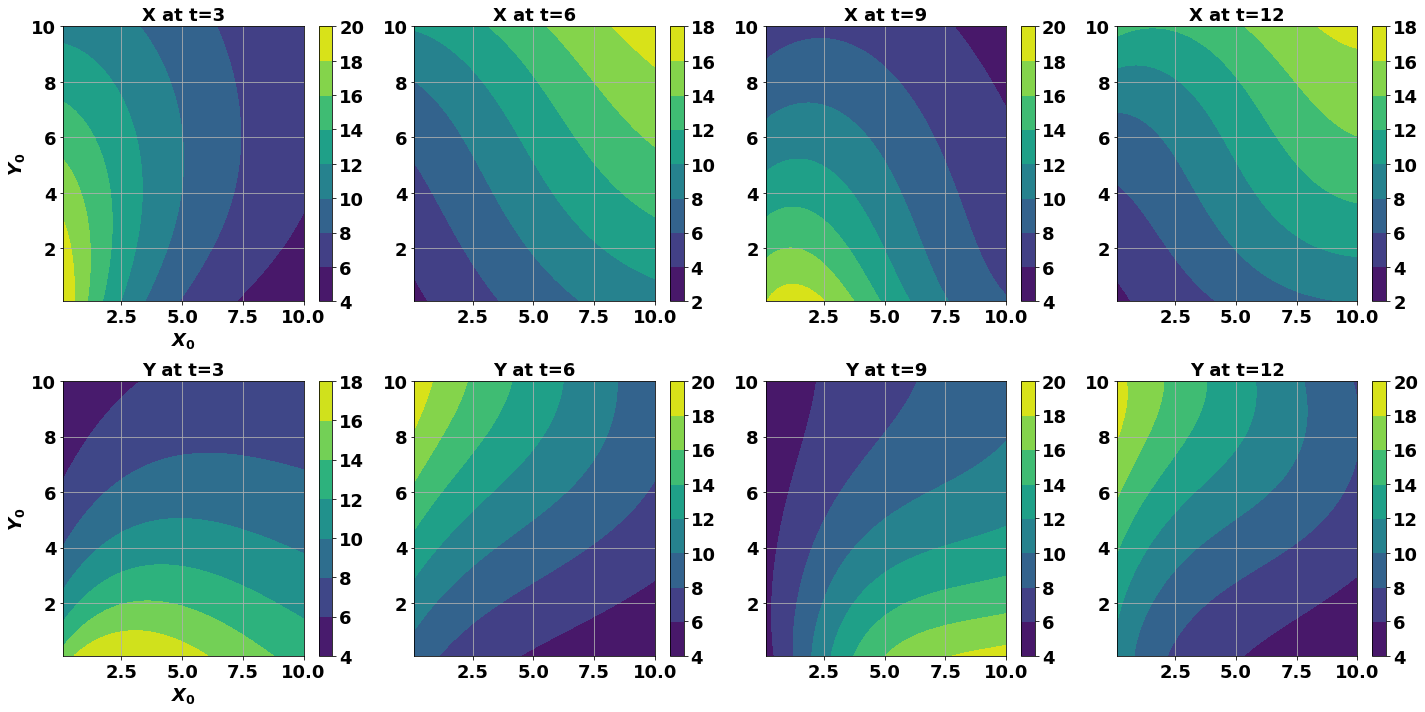

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


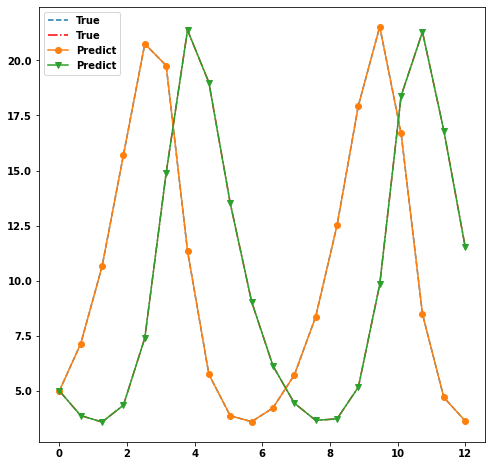

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


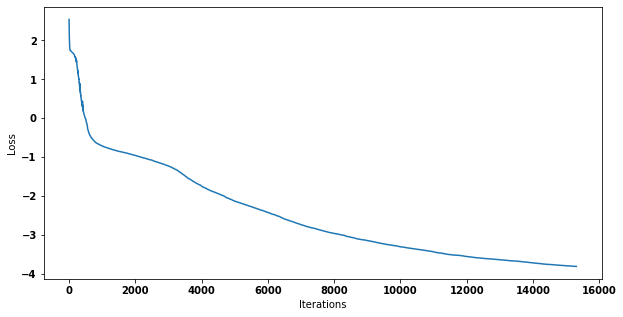

No handles with labels found to put in legend.


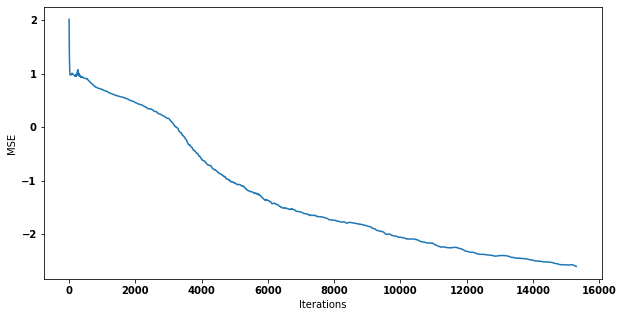

No handles with labels found to put in legend.


总计用时:1395.2191021442413 s


In [1]:
import time
import torch
import numpy as np
from matplotlib import pyplot as plt
from utils import set_seed, FCNN
from choose_optimizer import choose_optimizer
import skopt
from torch.optim.lr_scheduler import StepLR

class PINN(torch.nn.Module):
    def __init__(self, X_u_train, u_train, X_f_train, layers, lr, optimizer_name, iteration, X_test, U_test):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.x_u = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(self.device)
        self.y_u = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(self.device)
        self.t_u = torch.tensor(X_u_train[:, 2:3], requires_grad=True).float().to(self.device)
        self.x_f = torch.tensor(X_f_train[:, 0:1], requires_grad=True).float().to(self.device)
        self.y_f = torch.tensor(X_f_train[:, 1:2], requires_grad=True).float().to(self.device)
        self.t_f = torch.tensor(X_f_train[:, 2:3], requires_grad=True).float().to(self.device)
        self.t_0 = torch.tensor(np.zeros_like(X_f_train[:, 2:3]), requires_grad=True).float().to(self.device)
        self.u = torch.tensor(u_train, requires_grad=True).float().to(self.device)
        self.c11, self.c12, self.c13, self.c21, self.c22, self.c23 = 1.0, -0.1, 0.0, -1.0, 0.1, 0.0
        self.X_test = X_test
        self.U_test = U_test

        # Define basic net
        self.net = FCNN(layers)
        self.net.to(self.device)

        # Define the optimizers
        self.optimizer = choose_optimizer(optimizer_name, self.net.parameters(), lr)
        self.optimizer1 = choose_optimizer('LBFGS', self.net.parameters())
        self.iterations = iterations
        self.scheduler = StepLR(self.optimizer, step_size=10000, gamma=0.5)
        self.iter = 0
        self.loss, self.loss_u, self.loss_f, self.loss_0, self.loss_c, self.loss_c0, self.mse = [], [], [], [], [], [], []


    def net_u(self, x, y, t):
        u = self.net(torch.cat([x, y, t], dim=1))
        return u

    def net_f(self, x, y, t):
        u = self.net_u(x, y, t)
        R, A = u[:, 0:1], u[:, 1:2]

        R_t = torch.autograd.grad(
            R, t,
            grad_outputs=torch.ones_like(R),
            create_graph=True,
            retain_graph=True,
        )[0]

        R_x = torch.autograd.grad(
            R, x,
            grad_outputs=torch.ones_like(R),
            create_graph=True,
            retain_graph=True,
        )[0]

        R_y = torch.autograd.grad(
            R, y,
            grad_outputs=torch.ones_like(R),
            create_graph=True,
            retain_graph=True,
        )[0]

        R_xt = torch.autograd.grad(
            R_x, t,
            grad_outputs=torch.ones_like(R_x),
            create_graph=True,
            retain_graph=True,
        )[0]

        R_yt = torch.autograd.grad(
            R_y, t,
            grad_outputs=torch.ones_like(R_y),
            create_graph=True,
            retain_graph=True,
        )[0]

        A_t = torch.autograd.grad(
            A, t,
            grad_outputs=torch.ones_like(A),
            create_graph=True,
            retain_graph=True,
        )[0]

        A_x = torch.autograd.grad(
            A, x,
            grad_outputs=torch.ones_like(A),
            create_graph=True,
            retain_graph=True,
        )[0]

        A_y = torch.autograd.grad(
            A, y,
            grad_outputs=torch.ones_like(A),
            create_graph=True,
            retain_graph=True,
        )[0]

        A_xt = torch.autograd.grad(
            A_x, t,
            grad_outputs=torch.ones_like(A_x),
            create_graph=True,
            retain_graph=True,
        )[0]

        A_yt = torch.autograd.grad(
            A_y, t,
            grad_outputs=torch.ones_like(A_y),
            create_graph=True,
            retain_graph=True,
        )[0]

        f1 = R_t - self.c11 * R - self.c12 * R * A - self.c13 * R ** 2
        f2 = A_t - self.c21 * A - self.c22 * R * A - self.c23 * A ** 2
        f3 = R_xt - self.c11 * R_x - self.c12 * R_x * A - self.c12 * R * A_x - 2 * self.c13 * R * R_x
        f4 = R_yt - self.c11 * R_y - self.c12 * R_y * A - self.c12 * R * A_y - 2 * self.c13 * R * R_y
        f5 = A_xt - self.c21 * A_x - self.c22 * R_x * A - self.c22 * R * A_x - 2 * self.c23 * A * A_x
        f6 = A_yt - self.c21 * A_y - self.c22 * R_y * A - self.c22 * R * A_y - 2 * self.c23 * A * A_y

        return f1, f2, f3, f4, f5, f6

    def net_u0(self, x, y, t):
        u = self.net_u(x, y, t)
        R, A = u[:, 0:1], u[:, 1:2]

        R0 = R - x
        A0 = A - y

        return R0, A0

    def net_c0(self, x, y, t):
        u = self.net_u(x, y, t)
        R, A = u[:, 0:1], u[:, 1:2]

        R_x = torch.autograd.grad(
            R, x,
            grad_outputs=torch.ones_like(R),
            create_graph=True,
            retain_graph=True,
        )[0]

        R_y = torch.autograd.grad(
            R, y,
            grad_outputs=torch.ones_like(R),
            create_graph=True,
            retain_graph=True,
        )[0]

        A_x = torch.autograd.grad(
            A, x,
            grad_outputs=torch.ones_like(A),
            create_graph=True,
            retain_graph=True,
        )[0]

        A_y = torch.autograd.grad(
            A, y,
            grad_outputs=torch.ones_like(A),
            create_graph=True,
            retain_graph=True,
        )[0]

        return R_x - 1, R_y, A_x, A_y - 1

    def loss_pinn(self, verbose=True):
        if torch.is_grad_enabled():
            self.optimizer.zero_grad()
            self.optimizer1.zero_grad()
        u_pred = self.net_u(self.x_u, self.y_u, self.t_u)
        f1, f2, f3, f4, f5, f6 = self.net_f(self.x_f, self.y_f, self.t_f)
        R0, A0 = self.net_u0(self.x_f, self.y_f, self.t_0)
        Rx0, Ry0, Ax0, Ay0 = self.net_c0(self.x_f, self.y_f, self.t_0)

        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f1 ** 2) + torch.mean(f2 ** 2)
        loss_0 = torch.mean(R0 ** 2) + torch.mean(A0 ** 2)
        loss_c = torch.mean(f3 ** 2) + torch.mean(f4 ** 2) + torch.mean(f5 ** 2) + torch.mean(f6 ** 2)
        loss_c0 = torch.mean(Rx0 ** 2) + torch.mean(Ry0 ** 2) + torch.mean(Ax0 ** 2) + torch.mean(Ay0 ** 2)

        loss = loss_u + loss_f + loss_0

        if loss.requires_grad:
            loss.backward()

        grad_norm = 0
        for p in self.net.parameters():
            param_norm = p.grad.detach().data.norm(2)
            grad_norm += param_norm.item() ** 2
        grad_norm = grad_norm ** 0.5

        if verbose:
            u_test_pred, _, _ = model.predict(self.X_test)
            mse = np.mean((u_test_pred.reshape(-1, 1) - self.U_test.reshape(-1, 1)) ** 2)
            self.mse.append(mse.item())
            if self.iter % 100 == 0:
                print(
                    'epoch %d, gradient: %.5e, loss: %.5e, loss_u: %.5e, loss_f: %.5e, loss_0: %.5e, loss_c: %.5e, loss_c0: %.5e, mse: %.5e' % (
                        self.iter, grad_norm, loss.item(), loss_u.item(), loss_f.item(), loss_0.item(), loss_c.item(),
                        loss_c0.item(), mse)
                )
            self.iter += 1
            self.loss.append(loss.cpu().detach().item())
            self.loss_f.append(loss_f.cpu().detach().item())
            self.loss_0.append(loss_0.cpu().detach().item())
            self.loss_u.append(loss_u.cpu().detach().item())
            self.loss_c.append(loss_c.cpu().detach().item())
            self.loss_c0.append(loss_c0.cpu().detach().item())

        return loss

    def train(self):
        self.net.train()
        for i in range(self.iterations):
            self.optimizer.step(self.loss_pinn)
            self.scheduler.step()
        print("The training process using adam is finished!")
        self.optimizer1.step(self.loss_pinn)

        return self.loss, self.loss_u, self.loss_f, self.loss_0, self.loss_c, self.loss_c0, self.mse

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(self.device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(self.device)
        t = torch.tensor(X[:, 2:3], requires_grad=True).float().to(self.device)

        self.net.eval()
        u = self.net_u(x, y, t)
        R_x = torch.autograd.grad(u[:, 0], x, grad_outputs=torch.ones_like(u[:, 0]), create_graph=True, retain_graph=True)[0]
        R_y = torch.autograd.grad(u[:, 0], y, grad_outputs=torch.ones_like(u[:, 0]), create_graph=True, retain_graph=True)[0]
        A_x = torch.autograd.grad(u[:, 1], x, grad_outputs=torch.ones_like(u[:, 1]), create_graph=True, retain_graph=True)[0]
        A_y = torch.autograd.grad(u[:, 1], y, grad_outputs=torch.ones_like(u[:, 1]), create_graph=True, retain_graph=True)[0]

        u = u.detach().cpu().numpy()
        R_x, R_y = R_x.detach().cpu().numpy(), R_y.detach().cpu().numpy()
        A_x, A_y = A_x.detach().cpu().numpy(), A_y.detach().cpu().numpy()

        u_x = np.hstack((R_x, R_y))
        u_y = np.hstack((A_x, A_y))

        return u, u_x, u_y

if __name__ == '__main__':
    # cuda
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Random seed
    set_seed(0)
    # Training epoch of Adam
    iterations = 500
    # Residual points
    N_f = 8192 * 2
    lb = np.array([5.0, 5.0, 0.0])
    ub = np.array([15.0, 15.0, 12.0])
    #  Optimizer
    optimizer_name = 'Adam'
    lr = 1e-3
    # Test data
    path = r'Lotka_Volterra_three/Data'
    file_test = r'/testing_data.npz'
    file_train = r'/training_data.npz'
    data_test = np.load(path + file_test)
    data_train = np.load(path + file_train)
    X_train, U_train = data_train['arr1'], data_train['arr2']
    X_test, U_test, us = data_test['arr1'], data_test['arr2'], data_test['arr3']
    # Train data
    space = [(lb[0], ub[0]), (lb[1], ub[1]), (lb[2], ub[2])]
    sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1)
    X_f_train = np.array(sampler.generate(space, N_f))
    X_u_train = X_train
    u_train = U_train
    print(u_train.shape)
    # Network layer
    layers = [3, 128, 128, 128, 128, 128, 128, 2]
    # Model
    model = PINN(X_u_train, u_train, X_f_train, layers, lr, optimizer_name, iterations, X_test, U_test)
    # Training
    start_time = time.time()
    loss, loss_u, loss_f, loss_0, loss_c, loss_c0, mse = model.train()
    end_time = time.time()
    # Saved the model
    torch.save(model.state_dict(), path + r'/PINN.pth')
    np.savez(path+r'/PINN_loss.npz', arr1=loss, arr2=loss_u, arr3=loss_f, arr4=loss_0, arr5=loss_c, arr6=loss_c0, arr7=mse)
    print('模型已保存/加载！')

    # Predict
    u_train_pred, _, _ = model.predict(X_train)
    u_test_pred, u_x_pred, u_y_pred = model.predict(X_test)

    file_name = r'/PINNs_Params_result.npz'
    np.savez(path + file_name, arr1=u_train_pred, arr2=u_test_pred, arr3=u_x_pred, arr4=u_y_pred)
    print("预测数据保存成功！")

    # Error
    error_u_relative = np.linalg.norm(u_train - u_train_pred, 2) / np.linalg.norm(u_train, 2)
    error_u_relative_test = np.linalg.norm(U_test - u_test_pred, 2) / np.linalg.norm(U_test, 2)
    print(f'Train Error {error_u_relative:.4e}, Test Error {error_u_relative_test:.4e}')
    u_test_pred = u_test_pred.reshape(us.shape[0], us.shape[1], us.shape[2], -1)

    t_eval = np.linspace(0, 12, 20)
    param_range = np.linspace(0.1, 10.0, 40)
    time_points = [3, 6, 9, 12]

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.weight'] = 'bold'
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    for t_idx, t in enumerate(time_points):
        t_index = np.argmin(np.abs(t_eval - t))

        x_values = u_test_pred[:, :, t_index, 0]
        y_values = u_test_pred[:, :, t_index, 1]

        ax_x = axes[0, t_idx]
        contour_x = ax_x.contourf(param_range, param_range, x_values, cmap='viridis')
        cbar = fig.colorbar(contour_x, ax=ax_x)
        if t_idx == 0:
            ax_x.set_xlabel('$X_0$', fontsize=18, fontweight='bold')
            ax_x.set_ylabel('$Y_0$', fontsize=18, fontweight='bold')
        ax_x.set_title(f'X at t={t}', fontsize=18, fontweight='bold')
        ax_x.grid(True)
        ax_x.tick_params(axis='x', labelsize=18)
        ax_x.tick_params(axis='y', labelsize=18)
        cbar.ax.tick_params(labelsize=18)

        ax_y = axes[1, t_idx]
        contour_y = ax_y.contourf(param_range, param_range, y_values, cmap='viridis')
        cbar = fig.colorbar(contour_y, ax=ax_y)
        if t_idx == 0:
            ax_y.set_xlabel('$X_0$', fontsize=18, fontweight='bold')
            ax_y.set_ylabel('$Y_0$', fontsize=18, fontweight='bold')
        ax_y.set_title(f'Y at t={t}', fontsize=18, fontweight='bold')
        ax_y.grid(True)
        ax_y.tick_params(axis='x', labelsize=18)
        ax_y.tick_params(axis='y', labelsize=18)
        cbar.ax.tick_params(labelsize=18)

    plt.tight_layout()
    plt.show()

    fig2 = plt.figure(figsize=(8, 8))
    plt.plot(X_train[:, 2:3], u_train[:, 0:1], linestyle='--', label='True')
    plt.plot(X_train[:, 2:3], u_train[:, 1:2], linestyle='-.', color='r', label='True')
    plt.plot(X_train[:, 2:3], u_train_pred[:, 0], marker='o', markersize=6, label='Predict')
    plt.plot(X_train[:, 2:3], u_train_pred[:, 1], marker='v', markersize=6, label='Predict')
    plt.legend()
    plt.show()
    plt.close()

    data_loss = np.load(path + r'/PINN_loss.npz')
    loss = data_loss['arr1']
    loss = np.log10(loss)
    fig3 = plt.figure(figsize=(10, 5))
    plt.plot(loss, label='With C.D.')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()
    plt.legend(fontsize=18)
    plt.close()

    mse = data_loss['arr7']
    mse = np.log10(mse)
    fig4 = plt.figure(figsize=(10, 5))
    plt.plot(mse, label='With C.D.')
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.show()
    plt.legend(fontsize=18)
    plt.close()

    time_used = end_time-start_time
    print(f'总计用时:{time_used} s')